In [33]:
import pickle

In [34]:
# conll 2003
!curl -O https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!curl -O https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 4645k    0  2039    0     0   1754      0  0:45:12  0:00:01  0:45:11  1754
 15 4645k   15  704k    0     0   336k      0  0:00:13  0:00:02  0:00:11  336k
 65 4645k   65 3027k    0     0   957k      0  0:00:04  0:00:03  0:00:01  958k
100 4645k  100 4645k    0     0  1154k      0  0:00:04  0:00:04 --:--:-- 1154k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1173k    0   666    0     0    469      0  0:4

In [35]:
with open('ner_train.pkl', 'rb') as f:
  corpus_train = pickle.load(f)

with open('ner_test.pkl', 'rb') as f:
  corpus_test = pickle.load(f)

In [36]:
train_inputs = []
train_targets = []

for sentence_tag_pairs in corpus_train:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  train_inputs.append(tokens)
  train_targets.append(target)

In [37]:
test_inputs = []
test_targets = []

for sentence_tag_pairs in corpus_test:
  tokens = []
  target = []
  for token, tag in sentence_tag_pairs:
    tokens.append(token)
    target.append(tag)
  test_inputs.append(tokens)
  test_targets.append(target)

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [39]:
MAX_VOCAB_SIZE = None

should_lowercase = False
word_tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    lower=should_lowercase,
    oov_token='UNK',
)

word_tokenizer.fit_on_texts(train_inputs)
train_inputs_int = word_tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = word_tokenizer.texts_to_sequences(test_inputs)

In [40]:
word2idx = word_tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 23299 unique tokens.


In [41]:
def flatten(list_of_lists):
  flattened = [val for sublist in list_of_lists for val in sublist]
  return flattened

In [42]:
all_train_targets = set(flatten(train_targets))
all_train_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [43]:
all_test_targets = set(flatten(test_targets))
all_test_targets

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [44]:
all_train_targets == all_test_targets

True

In [45]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [46]:
maxlen_train = max(len(sent) for sent in train_inputs)
maxlen_test = max(len(sent) for sent in test_inputs)
T = max((maxlen_train, maxlen_test))

In [47]:
train_inputs_int = pad_sequences(train_inputs_int, maxlen=T)
print('Shape of data train tensor:', train_inputs_int.shape)

Shape of data train tensor: (12733, 113)


In [48]:
test_inputs_int = pad_sequences(test_inputs_int, maxlen=T)
print('Shape of data test tensor:', test_inputs_int.shape)

Shape of data test tensor: (2970, 113)


In [49]:
train_targets_int = pad_sequences(train_targets_int, maxlen=T)
print('Shape of train targets tensor:', train_targets_int.shape)

Shape of train targets tensor: (12733, 113)


In [50]:
test_targets_int = pad_sequences(test_targets_int, maxlen=T)
print('Shape of test targets tensor:', test_targets_int.shape)

Shape of test targets tensor: (2970, 113)


In [51]:
K = len(tag_tokenizer.word_index) + 1
K

10

In [52]:
D = 32

i = Input(shape=(T,))
x = Embedding(V + 1, D, mask_zero=True)(i)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [53]:
model.compile(
  loss=SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=5,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/5


398/398 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1274 - loss: 1.0481 - val_accuracy: 0.1312 - val_loss: 0.4826
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1248 - loss: 0.3342 - val_accuracy: 0.1382 - val_loss: 0.3190
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1308 - loss: 0.1886 - val_accuracy: 0.1433 - val_loss: 0.2226
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.1375 - loss: 0.0826 - val_accuracy: 0.1443 - val_loss: 0.1888
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.1390 - loss: 0.0464 - val_accuracy: 0.1445 - val_loss: 0.1795


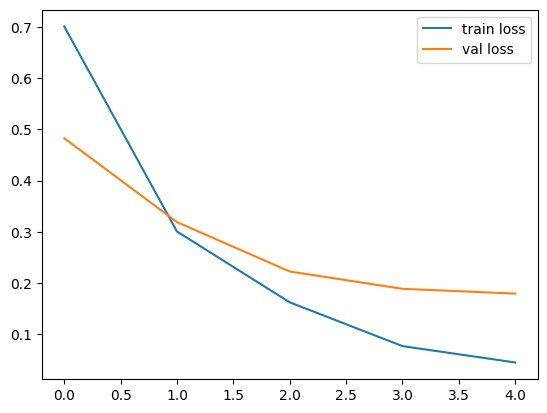

In [54]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

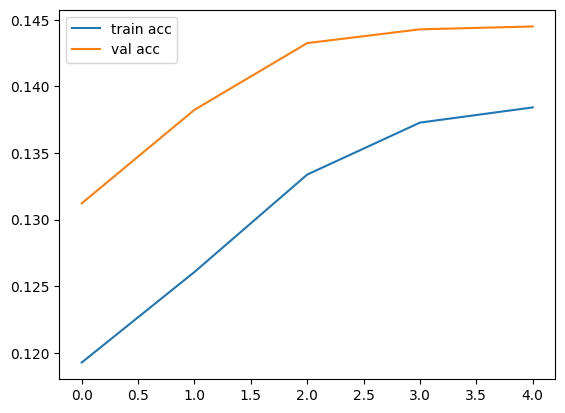

In [55]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [56]:
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))

In [57]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets_int_unpadded)

398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [58]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets_int_unpadded)

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [59]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.9935780181326547
Test acc: 0.9543459865792944
Train f1: 0.9545720021560332
Test f1: 0.800608859320398


In [60]:
from collections import Counter

def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0][0]

In [61]:
token2tags = {k: [] for k, v in word2idx.items()}

del token2tags['UNK']

for tokens, tags in zip(train_inputs, train_targets):
  for token, tag in zip(tokens, tags):
    if should_lowercase:
      token = token.lower()
    if token in token2tags:
      token2tags[token].append(tag)

for k, v in token2tags.items():
  if len(v) == 0:
    print(k)

token2tag = {k: most_common(v) for k, v in token2tags.items()}

In [62]:
train_predictions = []
for sentence in train_inputs:
  predictions = []
  for token in sentence:
    if should_lowercase:
      token = token.lower()
    predicted_tag = token2tag[token]
    predictions.append(predicted_tag)
  train_predictions.append(predictions)
flat_train_predictions = flatten(train_predictions)
flat_train_targets = flatten(train_targets)

In [63]:
test_predictions = []
for sentence in test_inputs:
  predictions = []
  for token in sentence:
    predicted_tag = token2tag.get(token, 'INCORRECT')
    predictions.append(predicted_tag)
  test_predictions.append(predictions)
flat_test_predictions = flatten(test_predictions)
flat_test_targets = flatten(test_targets)

In [64]:
print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))

Train acc: 0.974769365357086
Test acc: 0.8881673455733318
Train f1: 0.8549353965547479
Test f1: 0.6381158268902334
